<a href="https://colab.research.google.com/github/abcp4/AirbnbReviews/blob/main/Airbnb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise de tópicos em comentários da Airbnb

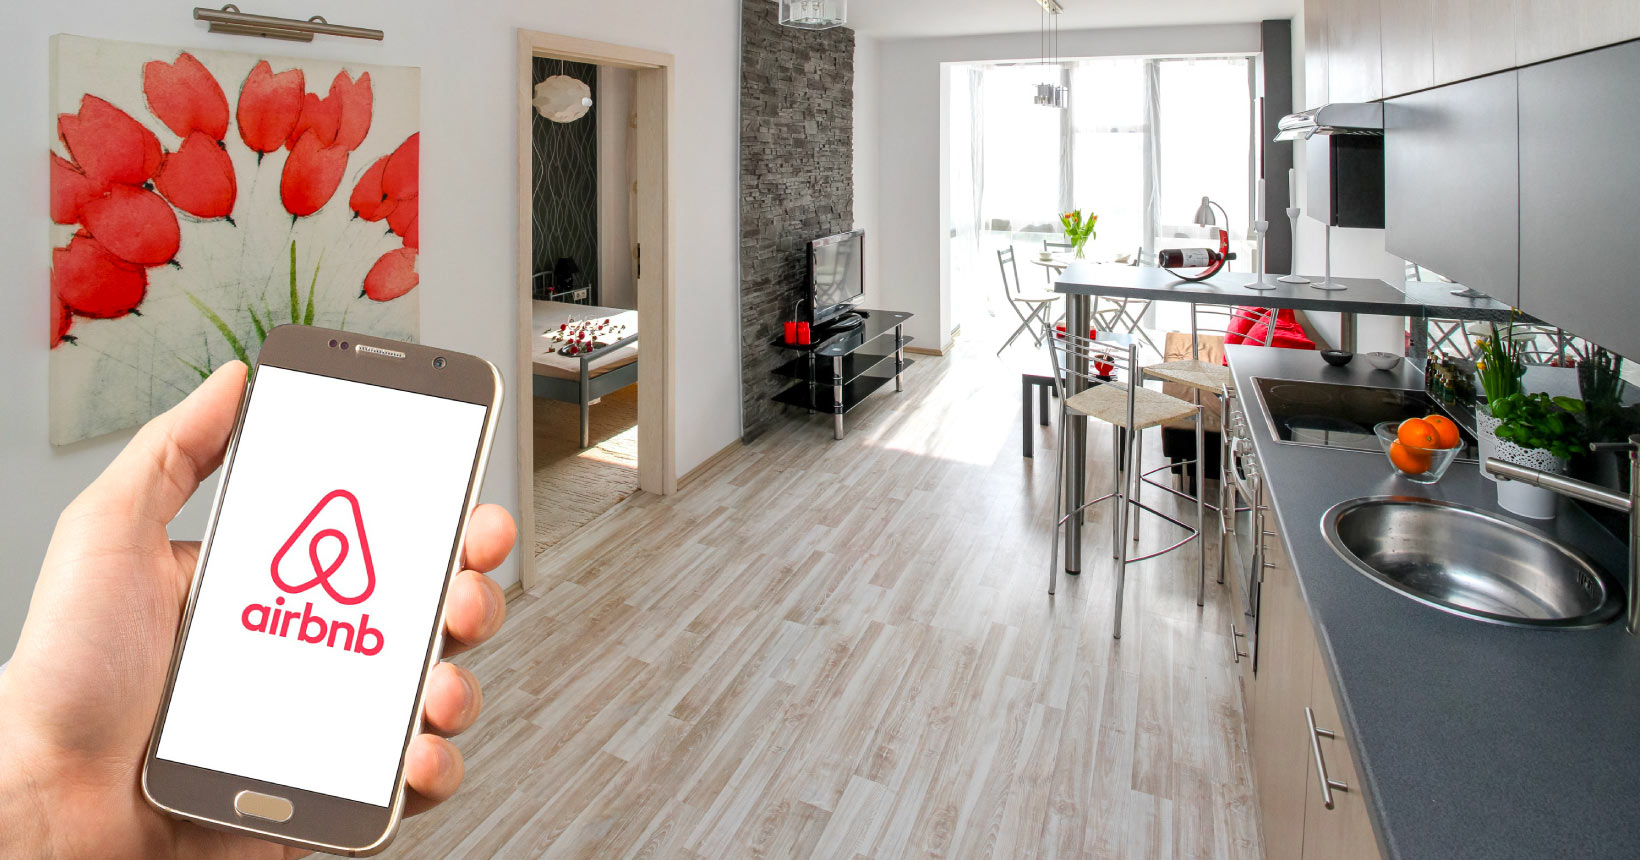

A Airbnb é uma empresa que opera no segmento de aluguel de hospedagem, ela permite que seus usuários disponibilizem ou realizem reservas de acomodoções em diversas localidades. Nesse notebook, pretendemos explorar o que as pessoas tem comentado sobre as acomodações, trazendo recortes com base em fatores como data, score, etc. Para a exploração proposta, utilizamos os dados referentes a cidade do Rio de Janeiro.

Nesse notebook, nos focamos nos aspecto de NLP: explorar apenas o campo textual dos reviews, com a variável resposta sendo o review_scores_rating



*   1. Análise do Dataset
*   2. Análise Exploratoria de dados(nos textos dos reviews)
*   3. Predição scores dos reviews
*   4. Classificação + Explicabilidade
*   5. Extra (Experimentação utilizando outros campos textuais)




# 1. Análise Dataset

O conjunto de dados pode ser obtido no [Inside Airbnb](http://insideairbnb.com/get-the-data.html), segundo o próprio site há informações geográficas, avaliações de clientes e dados do local alugado. Vamos no primeiro momento, realizar o _download_ dos dados e extrair as colunas de interesse em nossa análise.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
# Download de todos os dados de interesse

!wget http://data.insideairbnb.com/brazil/rj/rio-de-janeiro/2021-12-24/data/listings.csv.gz
!wget http://data.insideairbnb.com/brazil/rj/rio-de-janeiro/2021-12-24/data/calendar.csv.gz
!wget http://data.insideairbnb.com/brazil/rj/rio-de-janeiro/2021-12-24/data/reviews.csv.gz


--2022-03-21 00:24:12--  http://data.insideairbnb.com/brazil/rj/rio-de-janeiro/2021-12-24/data/listings.csv.gz
Resolving data.insideairbnb.com (data.insideairbnb.com)... 52.216.77.203
Connecting to data.insideairbnb.com (data.insideairbnb.com)|52.216.77.203|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14852915 (14M) [application/x-gzip]
Saving to: ‘listings.csv.gz’

listings.csv.gz     100%[===================>]  14.16M  32.9MB/s    in 0.4s    

2022-03-21 00:24:13 (32.9 MB/s) - ‘listings.csv.gz’ saved [14852915/14852915]

--2022-03-21 00:24:13--  http://data.insideairbnb.com/brazil/rj/rio-de-janeiro/2021-12-24/data/calendar.csv.gz
Resolving data.insideairbnb.com (data.insideairbnb.com)... 52.216.77.203
Connecting to data.insideairbnb.com (data.insideairbnb.com)|52.216.77.203|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25944363 (25M) [application/x-gzip]
Saving to: ‘calendar.csv.gz’

calendar.csv.gz     100%[===================>]

## 1.1 Análise inicial do dataset

1. Identificar colunas de interesse
2. Identificar presença de valores faltantes

In [3]:
import pandas as pd

listings = pd.read_csv('listings.csv.gz', compression='gzip')
calendar = pd.read_csv('calendar.csv.gz', compression='gzip')
reviews = pd.read_csv('reviews.csv.gz', compression='gzip')

In [2]:
print("--------------------------| Listings |--------------------------------")
print(listings.info())
print("\n--------------------------------| Calendar |--------------------------------")
print(calendar.info())
print("\n--------------------------------| Reviews  |--------------------------------")
print(reviews.info())

--------------------------| Listings |--------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24549 entries, 0 to 24548
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            24549 non-null  int64  
 1   listing_url                                   24549 non-null  object 
 2   scrape_id                                     24549 non-null  int64  
 3   last_scraped                                  24549 non-null  object 
 4   name                                          24528 non-null  object 
 5   description                                   23336 non-null  object 
 6   neighborhood_overview                         13212 non-null  object 
 7   picture_url                                   24549 non-null  object 
 8   host_id                                       24549 non-null  int

#2. EDA Textos das Reviews

Aqui fazemos uma análise do conteúdo textual das reviews. Em destaque está a segmentação dos principais assuntos das reviews, feita por meio da nuvem de palavras e modelos de tópicos.

##Carregar dados

In [ ]:
!pip install tomotopy
!pip install unidecode

     |████████████████████████████████| 16.3 MB 4.3 MB/s 


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import pandas as pd

listings = pd.read_csv('listings.csv.gz', compression='gzip')
reviews = pd.read_csv('reviews.csv.gz', compression='gzip')

In [ ]:
selected_columns = [
  "id", "neighbourhood_cleansed", "property_type", "review_scores_rating", "price"
]

listings = listings[selected_columns]
listings.head()

id neighbourhood_cleansed               property_type  \
0  17878             Copacabana  Entire condominium (condo)   
1  24480                Ipanema          Entire rental unit   
2  25026             Copacabana          Entire rental unit   
3  35636                Ipanema          Entire rental unit   
4  35764             Copacabana                 Entire loft   

   review_scores_rating    price  
0                  4.68  $350.00  
1                  4.73  $296.00  
2                  4.68  $387.00  
3                  4.72  $172.00  
4                  4.89  $260.00

In [ ]:
selected_columns = ["listing_id", "date", "comments"]
reviews = reviews[selected_columns]
reviews.head()

listing_id        date                                           comments
0       17878  2010-07-15  This apartment is in a perfect location -- two...
1       17878  2010-08-11  we had a really great experience staying in Ma...
2       17878  2010-09-06  Staying in Max appartment is like living in a ...
3       17878  2010-11-12  In general very good and reasonable price.\r<b...
4       17878  2010-12-01  The apt was nice and in a great location only ...

In [ ]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356118 entries, 0 to 356117
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   listing_id  356118 non-null  int64 
 1   date        356118 non-null  object
 2   comments    355995 non-null  object
dtypes: int64(1), object(2)
memory usage: 8.2+ MB


In [ ]:
reviews = reviews.dropna()
reviews["date"] = pd.to_datetime(reviews["date"])
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 355995 entries, 0 to 356117
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   listing_id  355995 non-null  int64         
 1   date        355995 non-null  datetime64[ns]
 2   comments    355995 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 10.9+ MB


### Pré-processamento

- Padronizar palavras (minúsculas)
- Remover pontuação
- Remover nans com base nos comentários
- Discretizar faixa de tempo
- Discretizar pontuação

In [ ]:
import string
from nltk.corpus import stopwords
import unidecode
custom_stopwords=["apartamento", "super", "bem",'bom', "excelent",'excelente','host','check',
                  'recomendo','lugar','certeza','estadia','apartment','gut','tres',
                  'nice','vezes','good','apto','buena','casa','time','localizado',
                  'extremamente','alem','pra',
                  'otima','otimo','tudo','great','stay','place','sempre','bien','boa',
                  'wohnung' ,'lage' ,'rio' ,'strand' ,'очень' ,'dia' ,'pois' ,
                  'everything' ,'location'  ,'departamento' ,
                  'ubicacion' ,'recomendable' ,'appartement' ,'sejour' ,'tout' ,
                  'rio' ,'situe','cerca','siempre','beach','would','one','clean','well',
                  'playa','cerca','perto','otima','close',
                  'perfect','would','ser','comodo','otimo','quarto',
                  'plage', 'quartier', 'propre', 'recommande', 'agreable', 'recommend',
                  'really', 'amazing', 'really', 'helpful', 'best', 'melhor',
                  'anfitria', 'atenciosa', 'aconchegante',
                   'fica', 'comfortable', 'excellent', 'definitely',
                  'limpio', 'lindo', 'mejor', 'plus', 'logement',
                  'ubicado', 'pore', 'ubicado', 'solo', 'gracias', 'atencion', 'seguro',
                   'hote', 'merci', 'parfait', 'agradavel', 'perfeita',
                   'local', 'pouco', 'perfeito', 'incrivel',
                  'bastante', 'adoramos', 'realmente', 'adorei', 'etc', 'obrigado', 
                  'maravilhoso','maravilhosa','even','thanks','lovely','fantastic','need',
                  'precisa', 'airbnb', 'janeiro','completo','home','predio','zona','area',
                  'ainda', 'algumas', 'alguns', 'apesar', 'apt', 'apos', 'apenas', 'assim', 
                  'caso', 'chegamos' ,'chegar', 'disse', 'disso','fazer', 'fez', 'ficou',
                  'fiquei', 'iria', 'left', 'pode', 'mim', 'maria', 'porem', 'possivel', 'quase',
                  'quer'
                   ]
stop_words= stopwords.words('english') + stopwords.words('portuguese') + stopwords.words('spanish') + stopwords.words('french') + stopwords.words('german') + custom_stopwords
stop_words=set([unidecode.unidecode(s.lower()) for s in stop_words])
puncts = {sp_character: ' ' for sp_character in string.punctuation} 
table = str.maketrans(puncts)

In [ ]:
import numpy as np
import gensim
from gensim.models.phrases import Phrases

def clean_commnents(texts: pd.Series) -> pd.Series:
    commnents = texts.copy()
    # remover pontuação
    commnents = commnents.str.translate(table)
    # remover caracteres especiais como acentuações
    commnents = commnents.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
    # altera todos o texto para minúscula
    commnents = commnents.str.lower()
    # remove excesso de espaços em branco
    commnents = commnents.str.replace(r'\s+',' ')
    # remove as stopwords
    commnents = commnents.apply(
      lambda sentence: ' '.join(
          [word for word in sentence.split() if word not in stop_words and len(word) > 2]
      )
    )
    # substitui strings vazia por nan
    commnents = commnents.replace(r'^\s*$', np.nan, regex=True)
    # remove espaços vazio no começo e fim da string
    return commnents.str.strip()

In [ ]:
reviews['comments'] = clean_commnents(reviews['comments'])
reviews.dropna(subset=['comments'], inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [ ]:
# Tokenize(split) the sentences into words
texts = [[text for text in doc.split()] for doc in reviews['comments']]

# Build the bigram models
bigram = gensim.models.Phrases(texts, min_count=25, threshold=5) 

In [ ]:
comments_bigrams = [
    ' '.join([word for word in bigram[line.split()]])
    for line in reviews['comments']
]

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
reviews["comments_bigrams"] = comments_bigrams
reviews.head()

listing_id       date                                           comments  \
0       17878 2010-07-15  two blocks two blocks copacabana palace anyone...   
1       17878 2010-08-11  experience staying max block copacabana easy a...   
2       17878 2010-09-06  staying max appartment like living cosy little...   
3       17878 2010-11-12  general reasonable price calls free give extra...   
4       17878 2010-12-01                         couple blocks shopping max   

                                    comments_bigrams  
0  two_blocks two_blocks copacabana_palace anyone...  
1  experience_staying max block_copacabana easy_a...  
2  staying max appartment like living cosy little...  
3  general reasonable_price calls free give extra...  
4                         couple_blocks shopping max

## Segmentação dos principais assuntos das reviews

- Considerando apenas os comentários
- Considerando comentários por tempo

In [ ]:
from wordcloud import WordCloud
from collections import Counter
from tqdm.notebook import tqdm, trange

def build_wordcloud(texts, name) -> WordCloud:
    wc = WordCloud(background_color='white', width=1600, height=800)
    counts_all = Counter()
    for line in tqdm(texts, desc=name): counts_all.update(wc.process_text(line))
    wc.generate_from_frequencies(counts_all)
    return wc

In [ ]:
# reviews['comments_bigrams'] = clean_commnents(reviews['comments_bigrams'])
reviews.dropna(subset=['comments_bigrams'], inplace=True)

df = pd.merge(
    reviews,
    listings,
    how="left",
    left_on="listing_id",
    right_on="id"
)

df = df[["listing_id", "date", "comments","comments_bigrams", "neighbourhood_cleansed", "review_scores_rating"]]
df.head()

listing_id       date                                           comments  \
0       17878 2010-07-15  two blocks two blocks copacabana palace anyone...   
1       17878 2010-08-11  experience staying max block copacabana easy a...   
2       17878 2010-09-06  staying max appartment like living cosy little...   
3       17878 2010-11-12  general reasonable price calls free give extra...   
4       17878 2010-12-01                         couple blocks shopping max   

                                    comments_bigrams neighbourhood_cleansed  \
0  two_blocks two_blocks copacabana_palace anyone...             Copacabana   
1  experience_staying max block_copacabana easy_a...             Copacabana   
2  staying max appartment like living cosy little...             Copacabana   
3  general reasonable_price calls free give extra...             Copacabana   
4                         couple_blocks shopping max             Copacabana   

   review_scores_rating  
0                  4.68  
1                  4.68  
2                  4.68  
3                  4.68  
4                  4.68

In [ ]:
df["review_scores_rating"].describe()

count    344427.000000
mean          4.787111
std           0.266713
min           0.000000
25%           4.720000
50%           4.840000
75%           4.930000
max           5.000000
Name: review_scores_rating, dtype: float64

In [ ]:
def reviews_labeling(value):
  if value <= 4:
    return "Faixa 0"
  if value <= 4.71:
    return "Faixa 1"
  if value <= 4.84:
    return "Faixa 2"
  if value <= 4.92:
    return "Faixa 3"
  if value <= 4.99:
    return "Faixa 4"
  return "Faixa 5"

In [ ]:
df["review_scores_intervals"] = df["review_scores_rating"].apply(reviews_labeling)
df.head()

listing_id       date                                           comments  \
0       17878 2010-07-15  two blocks two blocks copacabana palace anyone...   
1       17878 2010-08-11  experience staying max block copacabana easy a...   
2       17878 2010-09-06  staying max appartment like living cosy little...   
3       17878 2010-11-12  general reasonable price calls free give extra...   
4       17878 2010-12-01                         couple blocks shopping max   

                                    comments_bigrams neighbourhood_cleansed  \
0  two_blocks two_blocks copacabana_palace anyone...             Copacabana   
1  experience_staying max block_copacabana easy_a...             Copacabana   
2  staying max appartment like living cosy little...             Copacabana   
3  general reasonable_price calls free give extra...             Copacabana   
4                         couple_blocks shopping max             Copacabana   

   review_scores_rating review_scores_intervals  
0                  4.68                 Faixa 1  
1                  4.68                 Faixa 1  
2                  4.68                 Faixa 1  
3                  4.68                 Faixa 1  
4                  4.68                 Faixa 1

Palavras com contribuição semântica reduzida, conhecida como stopwords ou palavras vazias podem ser identificada através de nuvem de palavras. Para obtermos uma análise mais rica sobre os tema mais comentados, precisamos identificar palavras com pouca contribuição, por exemplo, conectivos, verbos auxiliares, etc.

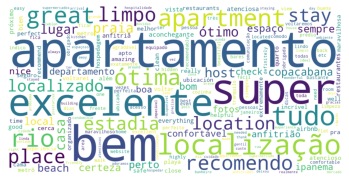

Realizando a remoção das palavras pelo NLTK, temos a nuvem de palavras gerada acima, em seguida adicionamos as palavras mais presentes acima em nossas stop_words e regeramos nossa nuvem.

reviews:   0%|          | 0/341999 [00:00<?, ?it/s]

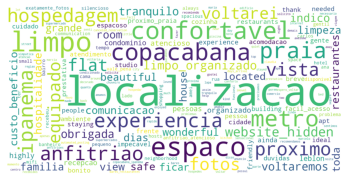

In [ ]:
import matplotlib.pyplot as plt

wc = build_wordcloud(reviews['comments_bigrams'], "reviews")

plt.imshow(wc)
plt.axis('off')
plt.show()

### Análise geral

Primeiro extraímos os tópicos de todos os tópicos no geral, consideramos um valor de 20 tópicos, mas poderia ser qualquer valor, queremos apenas identificar quais assuntos estão mais presentes nos comentários.

In [ ]:
import tomotopy as tp
mdl = tp.LDAModel(k=10, seed=1)
for _, tweet in df['comments_bigrams'].iteritems(): mdl.add_doc(tweet.split())
with trange(30) as t:
    for i in t:
        mdl.train(10)
        print(mdl.ll_per_word)
        # if i==0: first_loss=mdl.ll_per_word
        # t.set_description('Train: ' )
        # t.set_postfix(loss_0 = first_loss, loss_current=mdl.ll_per_word)
mdl.summary()

  0%|          | 0/30 [00:00<?, ?it/s]

-9.333855966984839
-8.991261808295048
-8.789476711740958
-8.686816061206448
-8.630351332293474
-8.59401268879025
-8.568304060319802
-8.548886116619295
-8.533030042048532
-8.526116489375946
-8.514515876877201
-8.506006333676346
-8.500199256863969
-8.49609388616124
-8.492480748360911
-8.487806018217297
-8.485742307014881
-8.48322382900873
-8.480921822898342
-8.478902464886945
-8.477379160974687
-8.475482385694846
-8.474796495899739
-8.473014495778841
-8.473667109541328
-8.472896886429709
-8.472142256429127
-8.471976741213075
-8.471343077077508
-8.471085133653398
<Basic Info>
| LDAModel (current version: 0.12.2)
| 341999 docs, 4684625 words
| Total Vocabs: 111457, Used Vocabs: 111457
| Entropy of words: 9.10268
| Entropy of term-weighted words: 9.10268
| Removed Vocabs: <NA>
|
<Training Info>
| Iterations: 300, Burn-in steps: 0
| Optimization Interval: 10
| Log-likelihood per word: -8.47109
|
<Initial Parameters>
| tw: TermWeight.ONE
| min_cf: 0 (minimum collection frequency of words)
| m

Resultado 10 tópicos principais 

In [ ]:

| #0 (614151) : localizacao espaco limpo confortavel experiencia
| #1 (477330) : localizacao praia espaco proximo confortavel
| #2 (627611) : copacabana fotos metro recomiendo amable
| #3 (211837) : localizacao limpo espaco confortavel anfitriao
| #4 (161969) : copacabana chez metro lappartement vraiment
| #5 (453718) : localizacao porem limpeza banheiro apenas
| #6 (1308155) : copacabana room ipanema house view
| #7 (46800) : unterkunft gastgeber sauber aufenthalt copacabana
| #8 (658321) : localizacao praia limpo confortavel espaco
| #9 (124733) : automated_posting days_arrival canceled_reservation located ipanema

### Análise por faixa de tempo

In [ ]:
reviews["date"].value_counts().sort_index()

2010-06-07      1
2010-07-15      1
2010-07-29      1
2010-08-11      1
2010-08-26      1
             ... 
2021-12-21    171
2021-12-22    140
2021-12-23    129
2021-12-24     66
2021-12-25     16
Name: date, Length: 3820, dtype: int64

In [ ]:
reviews = reviews.set_index('date')
reviews['Year'] = reviews.index.year
reviews['Month'] = reviews.index.month
reviews['day'] = reviews.index.day
reviews['ids']=[i for i in range(len(reviews))]
reviews = reviews.set_index('ids')

In [ ]:
reviews.head()

listing_id                                           comments  \
ids                                                                  
0         17878  two blocks two blocks copacabana palace anyone...   
1         17878  experience staying max block copacabana easy a...   
2         17878  staying max appartment like living cosy little...   
3         17878  general reasonable price calls free give extra...   
4         17878                         couple blocks shopping max   

                                      comments_bigrams  Year  Month  day  
ids                                                                       
0    two_blocks two_blocks copacabana_palace anyone...  2010      7   15  
1    experience_staying max block_copacabana easy_a...  2010      8   11  
2    staying max appartment like living cosy little...  2010      9    6  
3    general reasonable_price calls free give extra...  2010     11   12  
4                           couple_blocks shopping max  2010     12    1

In [ ]:
reviews['Year'].describe()

count    341994.000000
mean       2018.669284
std           2.066817
min        2010.000000
25%        2017.000000
50%        2019.000000
75%        2020.000000
max        2021.000000
Name: Year, dtype: float64

Comentários foram coletados entre 07/06/2010 até 25/12/2021, uma faixa de aproxidamente 10 anos, como desejamos identificar assuntos por período de tempo.

- 2010-2017
- 2018-2019
- 2020-2021

In [ ]:
def discretize(year):
  if year <= 2017:
    return "2010-2017"
  if year <= 2019:
    return "2018-2019"
  if year <= 2021:
    return "2020-2021"

reviews['year_intervals'] = reviews['Year'].apply(discretize)

In [ ]:
reviews['year_intervals'].value_counts()

2020-2021    135854
2018-2019    116031
2010-2017     90109
Name: year_intervals, dtype: int64

In [ ]:
wcs = {}
for name, group in reviews.groupby('year_intervals'):
    wc = build_wordcloud(group['comments_bigrams'], name)
    wcs[name] = wc

2010-2017:   0%|          | 0/90109 [00:00<?, ?it/s]

2018-2019:   0%|          | 0/116031 [00:00<?, ?it/s]

2020-2021:   0%|          | 0/135854 [00:00<?, ?it/s]

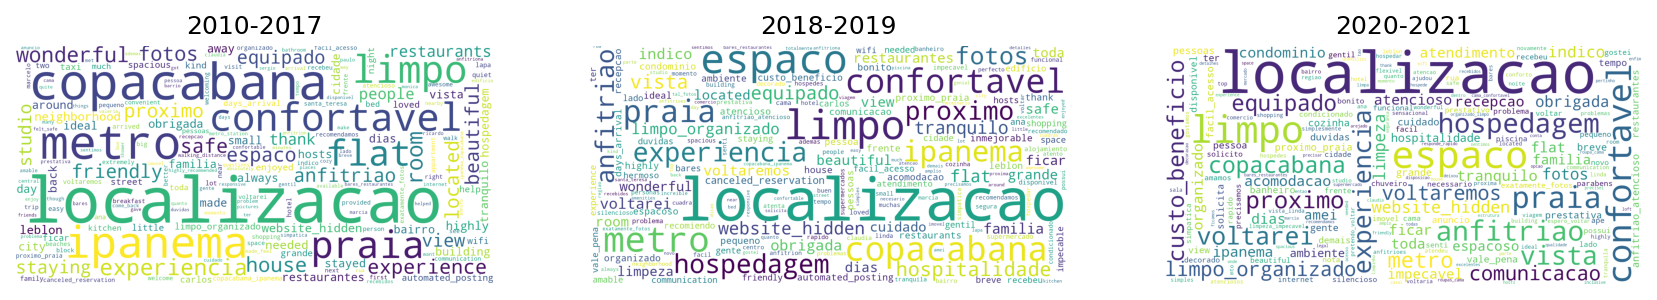

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(14, 10), dpi=150)
for ax, (name, wc) in zip(axs.flat, wcs.items()):
    ax.title.set_text(name)
    ax.imshow(wc)
    ax.axis('off')
plt.show()

###Análise por faixa de review score

In [ ]:
df['review_scores_intervals'].value_counts()

Faixa 2    90049
Faixa 1    82658
Faixa 3    80402
Faixa 4    55059
Faixa 5    30838
Faixa 0     3048
Name: review_scores_intervals, dtype: int64

In [ ]:
wcs = {}
for name, group in df.groupby('review_scores_intervals'):
    wc = build_wordcloud(group['comments_bigrams'], name)
    wcs[name] = wc

Faixa 0:   0%|          | 0/3048 [00:00<?, ?it/s]

Faixa 1:   0%|          | 0/82637 [00:00<?, ?it/s]

Faixa 2:   0%|          | 0/90040 [00:00<?, ?it/s]

Faixa 3:   0%|          | 0/80389 [00:00<?, ?it/s]

Faixa 4:   0%|          | 0/55049 [00:00<?, ?it/s]

Faixa 5:   0%|          | 0/30831 [00:00<?, ?it/s]

In [ ]:
# wcs['Faixa 0'].words_

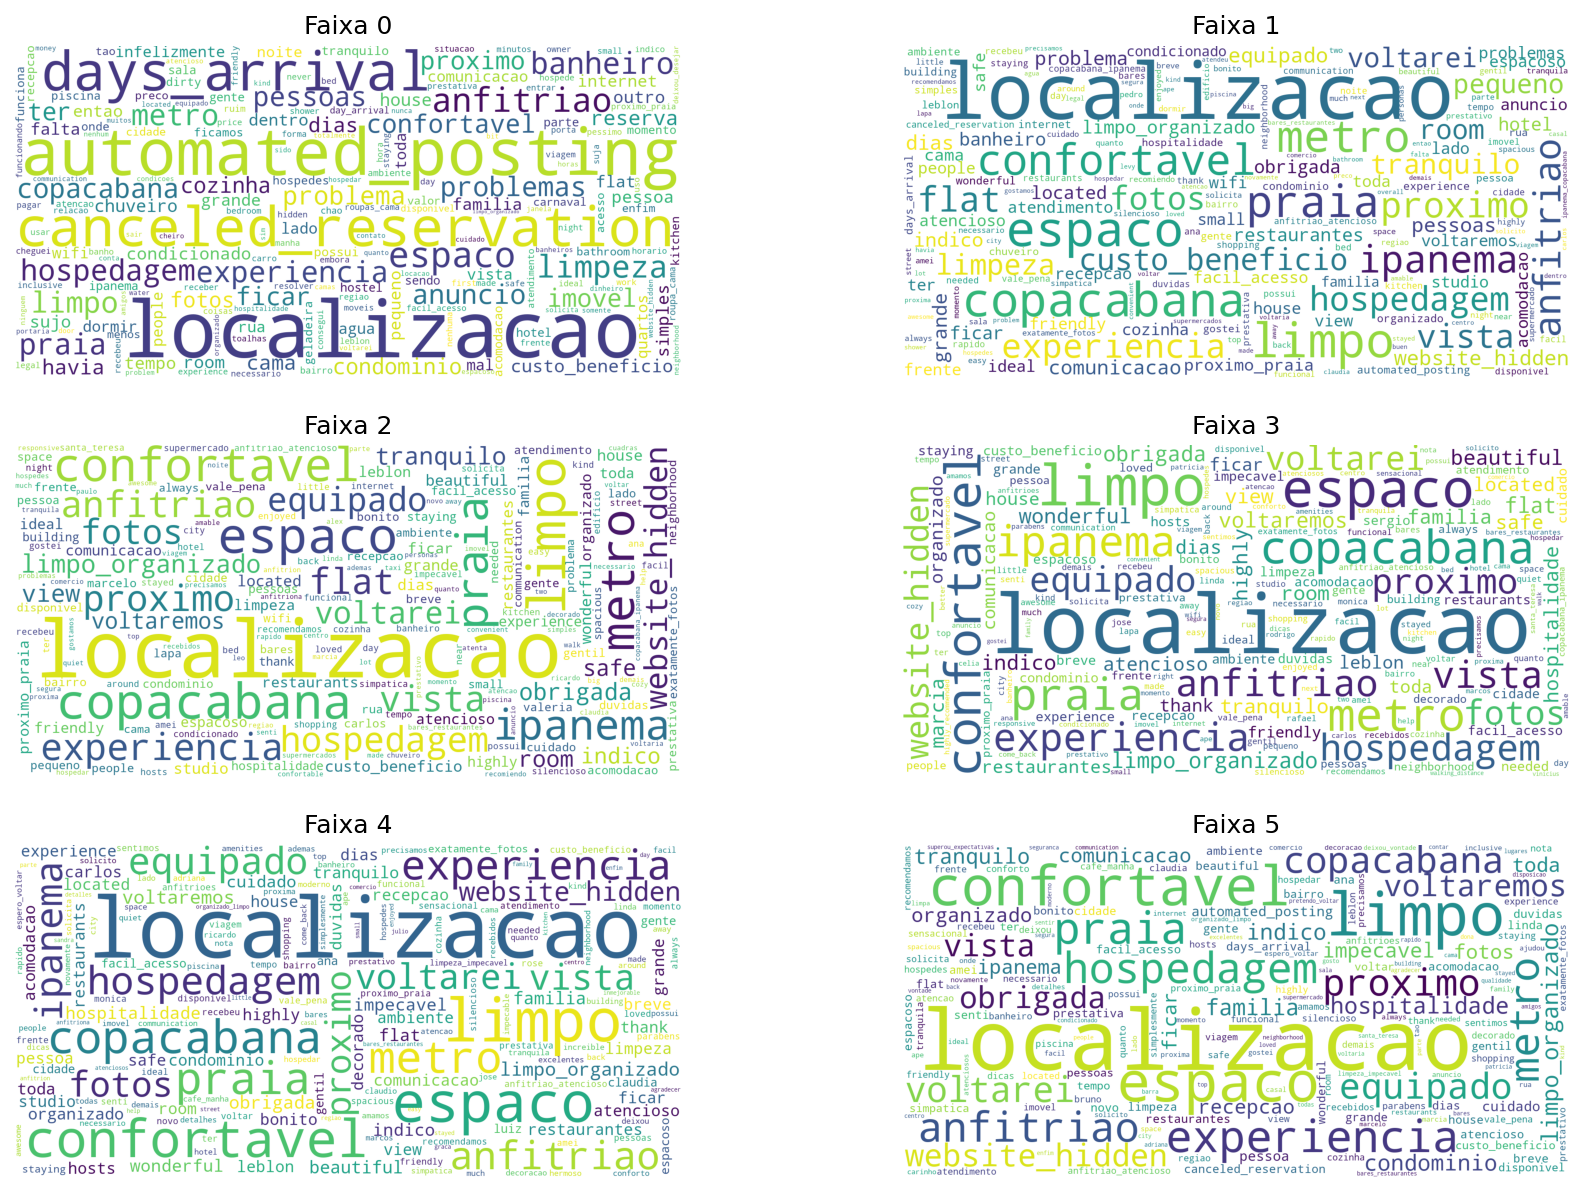

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(14, 10), dpi=150)
for ax, (name, wc) in zip(axs.flat, wcs.items()):
    ax.title.set_text(name)
    ax.imshow(wc)
    ax.axis('off')
plt.show()

#3. Predição scores dos Reviews

In [ ]:
!pip install unidecode

Nesta seção exploramos a tarefa de predição da variável de interesse review_scores_rating. Exploramos modelos lineares e redes neurais, dentre as quais modelos LSTM com atenção e o estado-da-arte transformers. Os resultados estão sumarizados na seção resultados

In [8]:
df = pd.merge(
    reviews,
    listings,
    how='inner',
    left_on='listing_id',
    right_on='id',
)
df = df[['listing_id','comments','review_scores_rating']]
df.head()

listing_id                                           comments  \
0       17878  This apartment is in a perfect location -- two...   
1       17878  we had a really great experience staying in Ma...   
2       17878  Staying in Max appartment is like living in a ...   
3       17878  In general very good and reasonable price.\r<b...   
4       17878  The apt was nice and in a great location only ...   

   review_scores_rating  
0                  4.68  
1                  4.68  
2                  4.68  
3                  4.68  
4                  4.68

In [9]:
len(df)

356118

In [10]:
df.dropna(inplace=True),len(df)

(None, 355995)

In [11]:
import unidecode
processed_texts=[]
c=0
for s in df['comments'].values:
  c+=1
  if c%10000==0:
    print(c)
  processed_texts.append(unidecode.unidecode(s.lower()))

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000


In [12]:
df['comments']=processed_texts

In [13]:
import string
puncts = {s: ' ' for s in string.punctuation}
table = str.maketrans(puncts)
df.comments = df.comments.str.translate(table)
df.comments = df.comments.str.replace(r'\s+',' ')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """


In [8]:
df['comments'].head()

0    this apartment is in a perfect location two bl...
1    we had a really great experience staying in ma...
2    staying in max appartment is like living in a ...
3    in general very good and reasonable price br b...
4    the apt was nice and in a great location only ...
Name: comments, dtype: object

In [14]:
df.to_csv('dataset.csv')

##Regressão Linear (Sklearn)

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
import unidecode
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [16]:
sample = df.comments.sample(frac=0.5, random_state=1).values
train_sample=[]
for s in sample[:]:
  train_sample.append(s)
count_vect = CountVectorizer()
count_vect.fit(train_sample)
labels = df['review_scores_rating'].values

In [17]:
features=count_vect.transform(df.comments)
features.shape

(355995, 81101)

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=1)

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score

clf=LinearRegression()
clf.fit(X_train, y_train)
y_pred= clf.predict(X_test)

In [22]:
mean_squared_error(y_test, y_pred),r2_score(y_test, y_pred)

(0.19445301553703423, -1.8203361933421367)

##Redes Neurais

###LSTM+Atenção

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.layers import GlobalMaxPooling1D, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import logging
import unidecode

logging.captureWarnings(True)
tf.compat.v1.disable_v2_behavior()

In [8]:
sample = df['comments'].sample(frac=0.5, random_state=1).values
train_sample=[]
for s in sample[:100000]:
  s=str(s)
  if(len(s)>10):
    train_sample.append(unidecode.unidecode(s.lower()))

In [9]:
'''
Construção do objeto tokenizador que transforma palavras em inteiros.
Ele suporta um total de 5000 palavras. Depois um padding é realizado para
limitar os tweets em 60 palavras.
'''

tokenizer = Tokenizer(num_words=20000, split=" ")
tokenizer.fit_on_texts(train_sample)

In [35]:
len(df)

356118

In [10]:
df.dropna(inplace=True),len(df)

(None, 355995)

In [11]:
X = tokenizer.texts_to_sequences(df['comments'].values)
X = pad_sequences(X, maxlen=100)
X.shape

(355995, 100)

In [12]:
import numpy as np
shuffled_indices = np.random.permutation(len(X)) #return a permutation of the indices

In [13]:
y=df['review_scores_rating'].values

# y=np.nan_to_num(y)
# y=np.log10(y+1)
# mean = y.mean()
# y = y - mean
# std = y.std()
# y = y / std

y=y[shuffled_indices]
X=X[shuffled_indices]

In [14]:
# # divisão treino e teste
# X_train, X_test, y_train, y_test = train_test_split(
#     X, , test_size=0.33, random_state=42)
X_train = X[:int(len(X)*0.70)]
y_train = y[:int(len(y)*0.70)]

X_test = X[int(len(X)*0.70):]
y_test = y[int(len(y)*0.70):]

In [15]:
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K

class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()

In [17]:
from tensorflow import keras
# definição do model da rede neural
inputs_1 = keras.layers.Input(shape=(X.shape[1]))

# inputs_1_dense = keras.layers.Dense(50, activation='relu')(inputs_1)
inputs_1_dense = Embedding(20000,50)(inputs_1)
lstm_out = keras.layers.LSTM(128,return_sequences=True)(inputs_1_dense)


input_all = keras.layers.Concatenate(axis=1)([lstm_out])
input_all=keras.layers.Flatten()(input_all)
real_output = keras.layers.Dense(1)(input_all)
model = keras.Model(inputs=[inputs_1], outputs=real_output)


# model.compile(loss='mean_squared_logarithmic_error',optimizer='adam',metrics=['mse'])
model.compile(loss='mse',optimizer='adam',metrics=['mse'])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 100, 50)           1000000   
                                                                 
 lstm_1 (LSTM)               (None, 100, 128)          91648     
                                                                 
 concatenate_1 (Concatenate)  (None, 100, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 12800)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                 12801     
                                                                 
Total params: 1,104,449
Trainable params: 1,104,449
Non-tra

In [18]:
# treinamento da rede
batch_size=64
epochs=3
historico=model.fit([X_train],y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1)

Train on 199356 samples, validate on 49840 samples
Epoch 1/3
199356/199356 [==============================] - 184s 922us/sample - loss: 0.1125 - mean_squared_error: 0.1125 - val_loss: 0.0593 - val_mean_squared_error: 0.0593
Epoch 2/3
199356/199356 [==============================] - 177s 887us/sample - loss: 0.0640 - mean_squared_error: 0.0640 - val_loss: 0.0591 - val_mean_squared_error: 0.0591
Epoch 3/3
199356/199356 [==============================] - 176s 884us/sample - loss: 0.0590 - mean_squared_error: 0.0590 - val_loss: 0.0604 - val_mean_squared_error: 0.0604


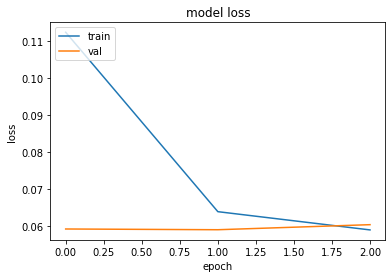

In [19]:
from matplotlib import pyplot as plt

plt.plot(historico.history['loss'])
plt.plot(historico.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

mse:  0.06416414855252957


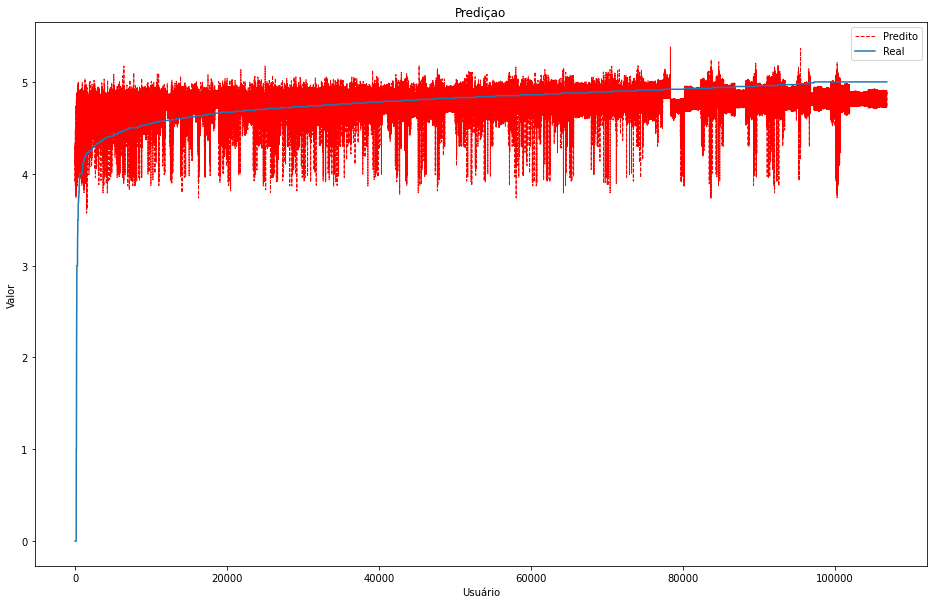

In [20]:
from matplotlib import pyplot as plt
import pandas as pd

resultadoRS = model.predict([X_test]).ravel()
esperadoRS = y_test.ravel()

mse = np.mean((np.array(esperadoRS) - np.array(resultadoRS))**2)
print('mse: ',mse)

indices = np.arange(0,resultadoRS.shape[0],1)
d = {'user':indices, 'real':esperadoRS,'predito':resultadoRS}
df_result = pd.DataFrame(d)
df_result = df_result.sort_values(by='predito')
df_result = df_result.sort_values(by='real')

y_real_sorted = df_result['real'].values
y_predict_sorted = df_result['predito'].values

plt.figure(num = 3, figsize=(16, 10))
plt.plot(indices,y_predict_sorted, label = "Predito",color='red', linewidth=1.0,  linestyle='--')
plt.plot(indices,y_real_sorted, label = "Real")
plt.xlabel("Usuário")
plt.ylabel("Valor")
plt.title("Prediçao")
plt.legend()
plt.show()

###LSTM+ Embeddings pré-treinados

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.layers import GlobalMaxPooling1D, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import logging
import unidecode

logging.captureWarnings(True)
tf.compat.v1.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [1]:
import pandas as pd
df = pd.read_csv('/content/dataset.csv')

In [3]:
df.dropna(inplace=True)

In [6]:
import unidecode
sample = df['comments'].sample(frac=0.5, random_state=1).values
train_sample=[]
for s in sample[:100000]:
  train_sample.append(unidecode.unidecode(s.lower()))

In [9]:
'''
Construção do objeto tokenizador que transforma palavras em inteiros.
Ele suporta um total de 5000 palavras. Depois um padding é realizado para
limitar os tweets em 60 palavras.
'''

tokenizer = Tokenizer(num_words=20000, split=" ")
tokenizer.fit_on_texts(train_sample)

In [10]:
voc = list(tokenizer.word_index)
word_index = dict(zip(voc, range(len(voc))))

In [17]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

In [32]:
#formas d ebaixar glove em pt
# !gdown https://drive.google.com/uc?id=1-3ZJuJ1_pwJO0Oy1zzD7Qgevpokh6W1m
# !wget http://143.107.183.175:22980/download.php?file=embeddings/glove/glove_s300.zip

#meu drive
!cp /content/drive/MyDrive/Sucupira/glove/model.zip .
!unzip model.zip

Archive:  model.zip
   creating: model/
  inflating: model/vocab.txt         
  inflating: model/vectors.txt       


In [22]:
import os
import numpy as np
path_to_glove_file = os.path.join(
    os.path.expanduser("~"), "/content/glove.6B.300d.txt"
)

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [23]:
num_tokens = len(voc) + 2
embedding_dim = 300
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 23608 words (37935 misses)


In [34]:
X = tokenizer.texts_to_sequences(df['comments'].values)
X = pad_sequences(X, maxlen=100)
X.shape

(355974, 100)

In [35]:
y=df['review_scores_rating'].values

y=np.nan_to_num(y)
# y=np.log10(y+1)
# mean = y.mean()
# y = y - mean
# std = y.std()
# y = y / std

# y=y[shuffled_indices]
# X=X[shuffled_indices]

In [37]:
# # divisão treino e teste
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,y, test_size=0.20, random_state=42)
# X_train = X[:int(len(X)*0.70)]
# y_train = y[:int(len(y)*0.70)]

# X_test = X[int(len(X)*0.70):]
# y_test = y[int(len(y)*0.70):]

In [38]:
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K

class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()

In [44]:
from tensorflow.keras.layers import Embedding
from tensorflow import keras
embedding_layer = Embedding(
    61545,
    300,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

In [45]:
from tensorflow import keras
# definição do model da rede neural
inputs_1 = keras.layers.Input(shape=(X.shape[1]))

# inputs_1_dense = keras.layers.Dense(50, activation='relu')(inputs_1)
# inputs_1_dense = Embedding(20000,50)(inputs_1)
inputs_1_dense = embedding_layer(inputs_1)
lstm_out = keras.layers.LSTM(128,return_sequences=True)(inputs_1_dense)
lstm_out = attention()(lstm_out)


# input_all = keras.layers.Concatenate(axis=1)([lstm_out])
input_all=keras.layers.Flatten()(lstm_out)
# input_all=keras.layers.GlobalMaxPooling1D()(lstm_out)
real_output = keras.layers.Dense(1)(input_all)
model = keras.Model(inputs=inputs_1, outputs=real_output)


# model.compile(loss='mean_squared_logarithmic_error',optimizer='adam',metrics=['mse'])
model.compile(loss='mse',optimizer='adam',metrics=['mse'])
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


2022-03-20 21:40:02.549392: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 100, 300)          18463500  
                                                                 
 lstm (LSTM)                 (None, 100, 128)          219648    
                                                                 
 attention (attention)       (None, 128)               228       
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 18,683,505
Trainable params: 220,005
Non-traina

In [46]:
# treinamento da rede
batch_size=128
epochs=5
historico=model.fit([X_train],y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1)

Train on 227823 samples, validate on 56956 samples


2022-03-20 21:40:07.746333: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 73854000 exceeds 10% of free system memory.
2022-03-20 21:40:07.965560: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 73854000 exceeds 10% of free system memory.
2022-03-20 21:40:08.137072: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 73854000 exceeds 10% of free system memory.
2022-03-20 21:40:08.163387: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 73854000 exceeds 10% of free system memory.
2022-03-20 21:40:08.242392: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 73854000 exceeds 10% of free system memory.


Epoch 1/5
227823/227823 [==============================] - 117s 515us/sample - loss: 0.1054 - mean_squared_error: 0.1054 - val_loss: 0.0742 - val_mean_squared_error: 0.0742
Epoch 2/5
227823/227823 [==============================] - 117s 515us/sample - loss: 0.0668 - mean_squared_error: 0.0668 - val_loss: 0.0700 - val_mean_squared_error: 0.0700
Epoch 3/5
227823/227823 [==============================] - 116s 509us/sample - loss: 0.0641 - mean_squared_error: 0.0641 - val_loss: 0.0689 - val_mean_squared_error: 0.0689
Epoch 4/5
227823/227823 [==============================] - 115s 504us/sample - loss: 0.0633 - mean_squared_error: 0.0633 - val_loss: 0.0684 - val_mean_squared_error: 0.0684
Epoch 5/5
227823/227823 [==============================] - 115s 506us/sample - loss: 0.0625 - mean_squared_error: 0.0625 - val_loss: 0.0685 - val_mean_squared_error: 0.0685


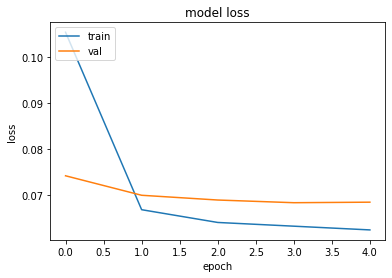

In [47]:
from matplotlib import pyplot as plt

plt.plot(historico.history['loss'])
plt.plot(historico.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

mse:  0.06524623495962832


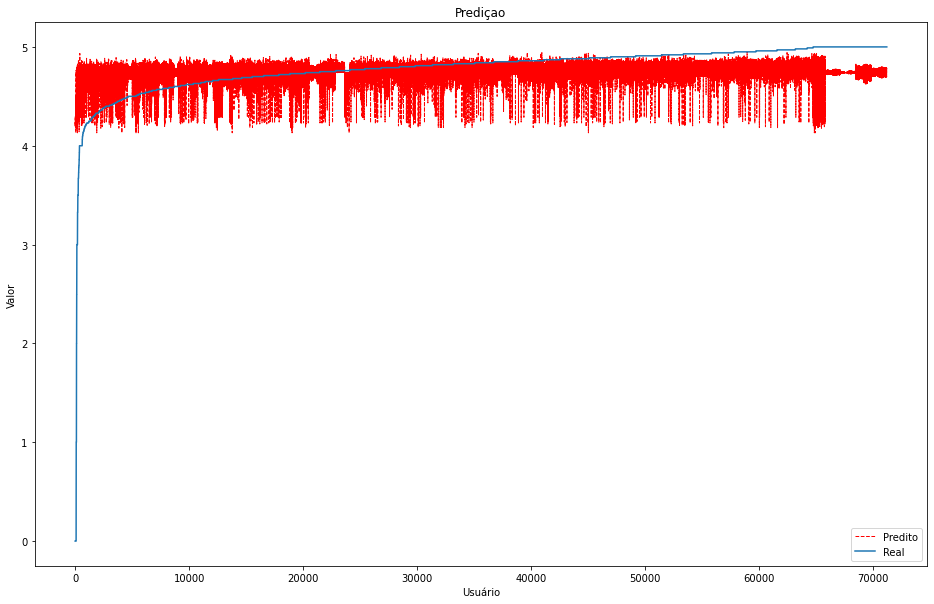

In [49]:
from matplotlib import pyplot as plt
import pandas as pd

resultadoRS = model.predict([X_test]).ravel()
esperadoRS = y_test.ravel()

mse = np.mean((np.array(esperadoRS) - np.array(resultadoRS))**2)
print('mse: ',mse)

indices = np.arange(0,resultadoRS.shape[0],1)
d = {'user':indices, 'real':esperadoRS,'predito':resultadoRS}
df_result = pd.DataFrame(d)
df_result = df_result.sort_values(by='predito')
df_result = df_result.sort_values(by='real')

y_real_sorted = df_result['real'].values
y_predict_sorted = df_result['predito'].values

plt.figure(num = 3, figsize=(16, 10))
plt.plot(indices,y_predict_sorted, label = "Predito",color='red', linewidth=1.0,  linestyle='--')
plt.plot(indices,y_real_sorted, label = "Real")
plt.xlabel("Usuário")
plt.ylabel("Valor")
plt.title("Prediçao")
plt.legend()
plt.show()

###Universal sentence encode(USE)

In [25]:
#"BERT"
!pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distiluse-base-multilingual-cased-v2')

In [26]:
embs=model.encode(df['comments'].values,show_progress_bar=True)

Batches:   0%|          | 0/11125 [00:00<?, ?it/s]

In [28]:
np.save('airbnb_embs.npy',embs)

In [34]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(embs, df['review_scores_rating'].values, test_size=0.2, random_state=1)

In [35]:
X_train.shape

(284796, 512)

In [36]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score

clf=LinearRegression()
clf.fit(X_train, y_train)
y_pred= clf.predict(X_test)

In [37]:
mean_squared_error(y_test, y_pred),r2_score(y_test, y_pred)

(0.06067911008474744, 0.11991341518068821)

mse:  0.06067911008474744


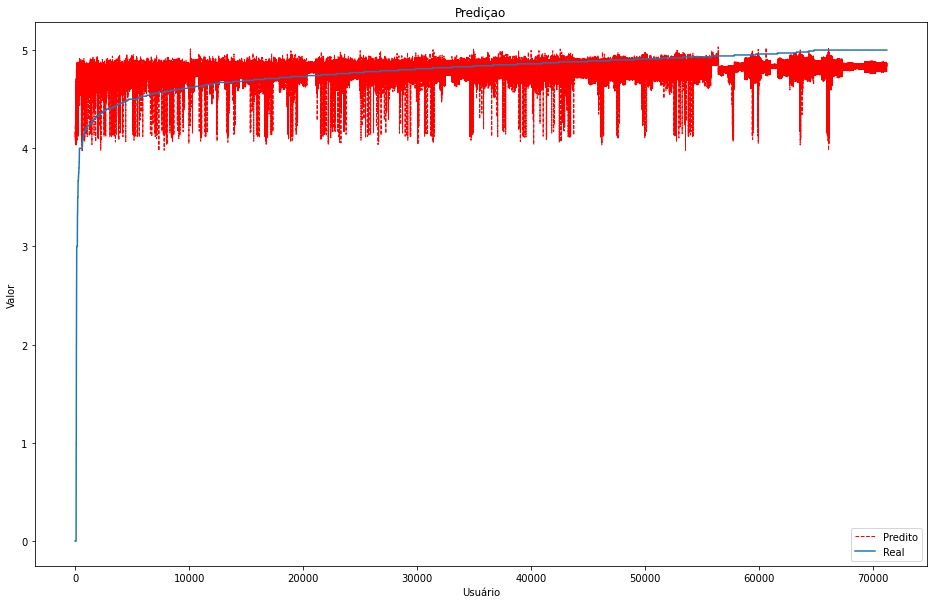

In [38]:
from matplotlib import pyplot as plt
import pandas as pd

resultadoRS = y_pred
esperadoRS = y_test

mse = np.mean((np.array(esperadoRS) - np.array(resultadoRS))**2)
print('mse: ',mse)

indices = np.arange(0,resultadoRS.shape[0],1)
d = {'user':indices, 'real':esperadoRS,'predito':resultadoRS}
df_result = pd.DataFrame(d)
df_result = df_result.sort_values(by='predito')
df_result = df_result.sort_values(by='real')

y_real_sorted = df_result['real'].values
y_predict_sorted = df_result['predito'].values

plt.figure(num = 3, figsize=(16, 10))
plt.plot(indices,y_predict_sorted, label = "Predito",color='red', linewidth=1.0,  linestyle='--')
plt.plot(indices,y_real_sorted, label = "Real")
plt.xlabel("Usuário")
plt.ylabel("Valor")
plt.title("Prediçao")
plt.legend()
plt.show()

###Transformers

In [1]:
import pandas as pd
df=pd.read_csv('dataset.csv')

In [22]:
pip install simpletransformers

     |████████████████████████████████| 248 kB 12.7 MB/s 
     |████████████████████████████████| 9.9 MB 43.3 MB/s 
     |████████████████████████████████| 1.7 MB 11.4 MB/s 
     |████████████████████████████████| 43 kB 2.4 MB/s 
     |████████████████████████████████| 325 kB 47.8 MB/s 
     |████████████████████████████████| 144 kB 65.8 MB/s 
     |████████████████████████████████| 181 kB 51.3 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
     |████████████████████████████████| 212 kB 70.2 MB/s 
     |████████████████████████████████| 127 kB 74.8 MB/s 
     |████████████████████████████████| 76 kB 6.4 MB/s 
     |████████████████████████████████| 164 kB 65.1 MB/s 
     |████████████████████████████████| 111 kB 70.0 MB/s 
     |████████████████████████████████| 4.3 MB 57.8 MB/s 
     |████████████████████████████████| 130 kB 71.7 MB/s 
     |████████████████████████████████| 793 kB 59.0 MB/s 
     |████████████████████████████████| 380 kB 62.0 MB/s 
  Created wheel for 

In [8]:
dataset={}
dataset['text'] = df['comments'].values
t=[float(b) for b in df['review_scores_rating'].values]
dataset['labels'] = t
dataset=pd.DataFrame().from_dict(dataset)

In [10]:
from sklearn.model_selection import train_test_split

train_df, eval_df = train_test_split(dataset, test_size=0.2, random_state=1)

In [14]:
!rm -r outputs
!rm -r cache_dir

rm: cannot remove 'outputs': No such file or directory


In [17]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import pandas as pd
import logging
import torch

logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

# Optional model configuration
model_args = ClassificationArgs()
model_args.num_train_epochs=1
model_args.regression = True
# model_args.num_labels=1
# model_args.max_seq_length=128
cuda_available = torch.cuda.is_available()

# Create a ClassificationModel
model = ClassificationModel(
    "distilbert", "distilbert-base-uncased", num_labels=1,
    args={
        "regression": True
    }
)

# Train the model
model.train_model(train_df)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'classifi

  0%|          | 0/284796 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_distilbert_128_1_2


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/35600 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
INFO:simpletransformers.classification.classification_model: Training of distilbert model complete. Saved to outputs/.


(35600, 0.17559583926519767)

In [18]:
result, model_outputs, wrong_predictions = model.eval_model(eval_df)

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/71199 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_distilbert_128_1_2


Running Evaluation:   0%|          | 0/8900 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'eval_loss': 0.0684684519988244}


In [22]:
eval_df['labels'].values

array([4.62, 4.97, 4.95, ..., 4.82, 4.94, 4.88])

In [21]:
model_outputs

array([4.89453125, 4.83984375, 4.8515625 , ..., 4.9296875 , 4.8984375 ,
       4.8125    ])

mse:  0.06846926445232673


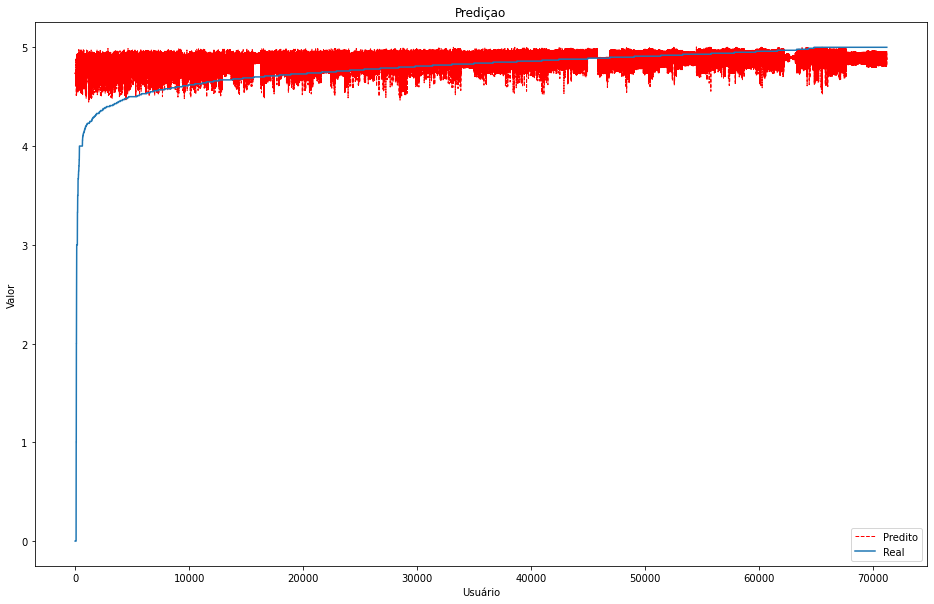

In [24]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
resultadoRS = model_outputs
esperadoRS = eval_df['labels'].values

mse = np.mean((np.array(esperadoRS) - np.array(resultadoRS))**2)
print('mse: ',mse)

indices = np.arange(0,resultadoRS.shape[0],1)
d = {'user':indices, 'real':esperadoRS,'predito':resultadoRS}
df_result = pd.DataFrame(d)
df_result = df_result.sort_values(by='predito')
df_result = df_result.sort_values(by='real')

y_real_sorted = df_result['real'].values
y_predict_sorted = df_result['predito'].values

plt.figure(num = 3, figsize=(16, 10))
plt.plot(indices,y_predict_sorted, label = "Predito",color='red', linewidth=1.0,  linestyle='--')
plt.plot(indices,y_real_sorted, label = "Real")
plt.xlabel("Usuário")
plt.ylabel("Valor")
plt.title("Prediçao")
plt.legend()
plt.show()

##Resultado Final

| Tables   |      Característica      |  MSE |
|----------|:-------------:|------:|
| Naive Bayes|  linear| 0.19 |
| **LSTM+Atenção** |    **não linear**   |   **0.059** |
| LSTM+Embeddings | não linear com conhecimento prévio |    0.065 |
| USE | linear com conhecimento prévio|    0.061 |
| Transformer | não linear com conhecimento prévio|    0.068 |

#4. Classificação + Explicabilidade

Aqui avaliamos a LSTM+atenção do keras e o modelo transformer na tarefa de classificação binária entre reviews negativos e positivos. Para os negativos escolhemos os reviews com score menor que 4 (bem poucos), e para os positivos os reviews com nota 5 (que são muitos). Escolhemos essas duas classes de forma a tornar o problema mais intuitivo, inclusive na técnica de explicabilidade apresentada depois.

In [1]:
import pandas as pd

df = pd.read_csv('dataset.csv')

In [2]:
df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

In [3]:
df.dropna(inplace=True),len(df)

(None, 355974)

Transformar o problema em classificação: Classe nota baixa(notas menores que 4), classe nota média(de 4.71 a 4.92), e classe nota perfeita(notas iguais a 5). Todo o resto é colocado na classe 3, a qual é descartada.Podemos dessa  forma avaliar quais os termos que mais contribuem para essas classes.

In [4]:
def reviews_labeling(value):
  if value<4:
    return 0
  if value ==5:
    return 1
  if value >4.71 and value < 4.92:
    return 2
  return 3

In [5]:
df['review_scores_rating']=df['review_scores_rating'].apply(reviews_labeling)

In [6]:
df['review_scores_rating'].value_counts()

2    167579
3    154617
1     31898
0      1880
Name: review_scores_rating, dtype: int64

Vemos que existe um desbalanceamento muito grande entre as classes, logo vamos tirar uma amostra da classe 1(nota perfeita).

In [25]:
cl0=df[df['review_scores_rating']==0]
cl1=df[df['review_scores_rating']==1].sample(frac=0.1)
cl0.shape,cl1.shape

((1880, 3), (3190, 3))

Mantemos somente duas classes: as de pior nota, e as de nota perfeita. Essa decisão é tomada para simplificar o problema e termos resultados mais intuitivos.

In [8]:
dataset = pd.concat([cl0,cl1])
# dataset = pd.concat([cl0,cl1,cl2])
dataset.shape

(5070, 3)

In [9]:
dataset.head()

listing_id                                           comments  \
4727       171505   br buena experiencia la anfitriona hizo un gr...   
9912       274552  arilson is a very helpful host i managed to lo...   
9913       274552  the host canceled this reservation 43 days bef...   
10026      284762  apartamento bem apertado mas com o espaco muit...   
10027      284762  celina is an incredible host we stayed at her ...   

       review_scores_rating  
4727                      0  
9912                      0  
9913                      0  
10026                     0  
10027                     0

###keras

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.layers import GlobalMaxPooling1D, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import logging
import unidecode

logging.captureWarnings(True)
tf.compat.v1.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [12]:
sample = dataset['comments'].sample(frac=0.5, random_state=1).values
train_sample=[]
for s in sample[:100000]:
  train_sample.append(unidecode.unidecode(s.lower()))

In [13]:
'''
Construção do objeto tokenizador que transforma palavras em inteiros.
Ele suporta um total de 5000 palavras. Depois um padding é realizado para
limitar os tweets em 60 palavras.
'''
tokenizer = Tokenizer(num_words=20000, split=" ")
tokenizer.fit_on_texts(train_sample)

In [14]:
X = tokenizer.texts_to_sequences(dataset['comments'].values)
X = pad_sequences(X, maxlen=100)
X.shape

(5070, 100)

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, dataset['review_scores_rating'].values, test_size=0.20, random_state=42)

In [16]:
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K

class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()

In [22]:
from tensorflow import keras
# definição do model da rede neural
inputs_1 = keras.layers.Input(shape=(X.shape[1]))

# inputs_1_dense = keras.layers.Dense(50, activation='relu')(inputs_1)
inputs_1_dense = Embedding(20000,50)(inputs_1)
lstm_out = keras.layers.LSTM(128,return_sequences=True)(inputs_1_dense)
lstm_out = attention()(lstm_out)


input_all = keras.layers.Concatenate(axis=1)([lstm_out])
input_all=keras.layers.Flatten()(input_all)
real_output = keras.layers.Dense(2,activation='softmax')(input_all)
model = keras.Model(inputs=[inputs_1], outputs=real_output)


# model.compile(loss='mean_squared_logarithmic_error',optimizer='adam',metrics=['mse'])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['acc'])
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 100, 50)           1000000   
                                                                 
 lstm_3 (LSTM)               (None, 100, 128)          91648     
                                                                 
 attention_3 (attention)     (None, 128)               228       
                                                                 
 concatenate_3 (Concatenate)  (None, 128)              0         
                                                                 
 flatten_3 (Flatten)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 258 

In [23]:
# treinamento da rede
batch_size=64
epochs=10
historico=model.fit([X_train],y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1)

Train on 3244 samples, validate on 812 samples
Epoch 1/10
3244/3244 [==============================] - 5s 2ms/sample - loss: 0.6587 - acc: 0.6227 - val_loss: 0.6206 - val_acc: 0.6502
Epoch 2/10
3244/3244 [==============================] - 6s 2ms/sample - loss: 0.5121 - acc: 0.7515 - val_loss: 0.4502 - val_acc: 0.8054
Epoch 3/10
3244/3244 [==============================] - 5s 1ms/sample - loss: 0.3948 - acc: 0.8311 - val_loss: 0.4391 - val_acc: 0.8103
Epoch 4/10
3244/3244 [==============================] - 3s 1ms/sample - loss: 0.3184 - acc: 0.8668 - val_loss: 0.4395 - val_acc: 0.8202
Epoch 5/10
3244/3244 [==============================] - 3s 1ms/sample - loss: 0.2689 - acc: 0.8835 - val_loss: 0.4560 - val_acc: 0.8116
Epoch 6/10
3244/3244 [==============================] - 3s 1ms/sample - loss: 0.2296 - acc: 0.8967 - val_loss: 0.4697 - val_acc: 0.8190
Epoch 7/10
3244/3244 [==============================] - 4s 1ms/sample - loss: 0.1921 - acc: 0.9168 - val_loss: 0.5825 - val_acc: 0.8091
E

In [24]:
from sklearn.metrics import classification_report
import numpy as np
y_pred = model.predict(X_test)
print(classification_report(y_test, np.argmax(y_pred,axis=1)))

              precision    recall  f1-score   support

           0       0.67      0.75      0.71       387
           1       0.84      0.78      0.80       627

    accuracy                           0.77      1014
   macro avg       0.76      0.76      0.76      1014
weighted avg       0.77      0.77      0.77      1014



###Transformers

Aqui fazemos o retreinamento do modelo transformer na tarefa de classificação binária dos reviews. Esse é o melhor modelo para lidar com a falta de amostras para classe de reviews negativos. No fim, aplicamos a técnica de explicabilidade de Shap values para entender o que o modelo considera mais relevante nas amostras para sua tomada de decisão.

In [43]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    dataset['comments'].values, dataset['review_scores_rating'].values, test_size=0.20, random_state=42)

In [18]:
pip install simpletransformers

     |████████████████████████████████| 248 kB 2.3 MB/s 
     |████████████████████████████████| 6.5 MB 59.7 MB/s 
     |████████████████████████████████| 1.2 MB 57.7 MB/s 
     |████████████████████████████████| 3.8 MB 65.1 MB/s 
     |████████████████████████████████| 43 kB 2.8 MB/s 
     |████████████████████████████████| 1.7 MB 52.0 MB/s 
     |████████████████████████████████| 325 kB 67.5 MB/s 
     |████████████████████████████████| 9.9 MB 57.1 MB/s 
     |████████████████████████████████| 67 kB 6.7 MB/s 
     |████████████████████████████████| 596 kB 59.3 MB/s 
     |████████████████████████████████| 895 kB 61.5 MB/s 
     |████████████████████████████████| 181 kB 73.5 MB/s 
     |████████████████████████████████| 144 kB 70.3 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
     |████████████████████████████████| 212 kB 70.1 MB/s 
     |████████████████████████████████| 134 kB 72.7 MB/s 
     |████████████████████████████████| 1.1 MB 60.1 MB/s 
     |███████████████

In [44]:
d={}
d['text'] = dataset['comments'].values
d['labels'] = dataset['review_scores_rating'].values
d=pd.DataFrame().from_dict(d)

In [45]:
from sklearn.model_selection import train_test_split

train_df, eval_df = train_test_split(d, test_size=0.2, random_state=1)

In [46]:
!rm -r outputs
!rm -r cache_dir

rm: cannot remove 'outputs': No such file or directory
rm: cannot remove 'cache_dir': No such file or directory


In [47]:
train_df.head()

text  labels
4507  el departamento esta super equipado y terenzin...       1
4104  carla e uma anfitria extremamente prestativa e...       1
3074  excelente localizacao aconchegante simples lim...       1
4911  joana s place is certainly special it has an a...       1
4192  lovely apartment amazing location and a super ...       1

In [49]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import pandas as pd
import logging
import torch

logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

# Optional model configuration
model_args = ClassificationArgs()
model_args.num_train_epochs=1
# model_args.max_seq_length=128
cuda_available = torch.cuda.is_available()

# Create a ClassificationModel
model = ClassificationModel(
    "distilbert", "distilbert-base-uncased", num_labels=2,args=model_args
)

# Train the model
model.train_model(train_df)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier

  0%|          | 0/4056 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_distilbert_128_2_2
  FutureWarning,



Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/507 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of distilbert model complete. Saved to outputs/.


(507, 0.5037486134666428)

In [50]:
result, model_outputs, wrong_predictions = model.eval_model(eval_df)

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/1014 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_distilbert_128_2_2


Running Evaluation:   0%|          | 0/127 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.5359206199054866, 'tp': 577, 'tn': 221, 'fp': 162, 'fn': 54, 'auroc': 0.8084995013923773, 'auprc': 0.8333800013581065, 'eval_loss': 0.5296884972279466}


In [51]:
import numpy as np
y_pred =np.argmax(model_outputs,axis=1)
y_pred

array([0, 1, 1, ..., 1, 0, 1])

In [52]:
from sklearn.metrics import classification_report
print(classification_report(eval_df['labels'].values, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.58      0.67       383
           1       0.78      0.91      0.84       631

    accuracy                           0.79      1014
   macro avg       0.79      0.75      0.76      1014
weighted avg       0.79      0.79      0.78      1014



In [53]:
!pip install shap

     |████████████████████████████████| 564 kB 7.0 MB/s 


In [54]:
import shap
import transformers

In [55]:
pred = transformers.pipeline("text-classification", model=model.model, tokenizer=model.tokenizer, device=0, return_all_scores=True)

In [56]:
explainer = shap.Explainer(pred)

In [89]:
sample=pd.concat([cl0['comments'].sample(100),cl1['comments'].sample(100)])

In [91]:
len(sample.values[1])

224

In [92]:
sample =[s[:200] for s in sample if len(s)>20]

In [93]:
shap_values = explainer(sample)

A saída de streaming foi truncada nas últimas 5000 linhas.



Partition explainer:  69%|██████▉   | 132/192 [03:16<01:13,  1.22s/it]WARNING:py.warnings:You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset










































Partition explainer:  69%|██████▉   | 133/192 [03:18<01:21,  1.37s/it]WARNING:py.warnings:You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset










































Partition explainer:  70%|██████▉   | 134/192 [03:19<01:24,  1.47s/it]WARNING:py.warnings:You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset










































Partition explainer:  70%|███████   | 135/192 [03:21<01:28,  1.54s/it]WARNING:py.warnings:You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


















In [ ]:
shap.plots.text(shap_values)

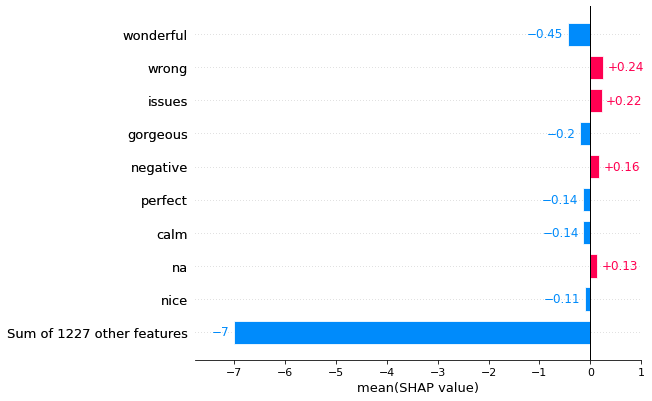

In [94]:
shap.plots.bar(shap_values[:,:,0].mean(0))

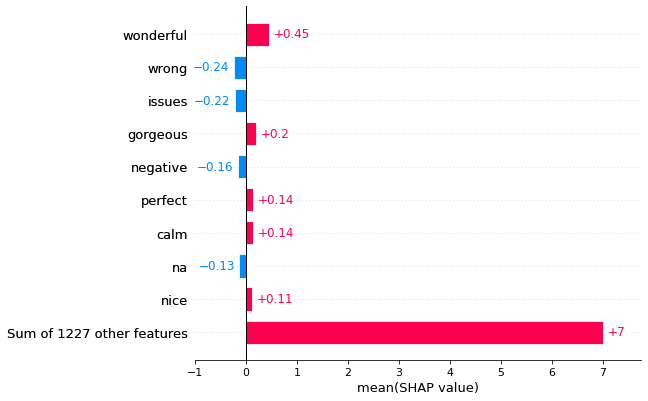

In [95]:
shap.plots.bar(shap_values[:,:,1].mean(0))

#5. Extra: Listing Análise

Nesta seção, fazemos os experimentos iniciais com o arquivo Listing, para prever a variável resposta reviews score. Nesse arquivos temos informações do dono do imóvel alocado, como por exemplo: um resumo sobre si mesmo, sobre a vizinhança, e sobre os objetos presentes no imóvel.

Primeiro é feita uma análise com regressão linear de cada campo textual. Depois, é proposta uma arquitetura de rede neural com multiplas entradas para cada campo de texto. A predição resultante parece se ajustar melhor aos valores de teste do que os resultados anteriores.

In [1]:
import pandas as pd

listings = pd.read_csv('listings.csv.gz', compression='gzip')

In [2]:
selected_columns = [
  "id", "description", "neighborhood_overview", "host_about",
  "neighbourhood_cleansed", "property_type", "amenities",
  "review_scores_rating", "price"
]

listings = listings[selected_columns]

In [3]:
listings.head()

id                                        description  \
0  17878  Discounts for long term stays. <br />- Large b...   
1  24480  My studio is located in the best of Ipanema, t...   
2  25026  Our apartment is a little gem, everyone loves ...   
3  35636  This cosy apartment  is just a few steps away ...   
4  35764  Our newly renovated studio is located in the b...   

                               neighborhood_overview  \
0  This is the one of the bests spots in Rio. Bec...   
1  The beach, the lagoon, Ipanema is a great loca...   
2  Copacabana is a lively neighborhood and the ap...   
3  The  apartment street is very quiet and safe ....   
4  Our guests will experience living with a local...   

                                          host_about neighbourhood_cleansed  \
0  I  am a  journalist/writer. Lived  in NYC for ...             Copacabana   
1  Welcome to Rio!\nI am a human being fighting f...                Ipanema   
2  Hi guys, We're a lovely team of 3 people:\r\n\...             Copacabana   
3  I am Brazilian and Carioca graphic designer, b...                Ipanema   
4  Hello,   We are Patricia Miranda and Paulo.\r\...             Copacabana   

                property_type  \
0  Entire condominium (condo)   
1          Entire rental unit   
2          Entire rental unit   
3          Entire rental unit   
4                 Entire loft   

                                           amenities  review_scores_rating  \
0  ["Bed linens", "Stove", "Elevator", "Cable TV"...                  4.68   
1  ["Extra pillows and blankets", "Dining table",...                  4.73   
2  ["Free street parking", "Dining table", "Bed l...                  4.68   
3  ["Washer", "Cleaning before checkout", "Free s...                  4.72   
4  ["Beachfront", "Extra pillows and blankets", "...                  4.89   

     price  
0  $350.00  
1  $296.00  
2  $387.00  
3  $172.00  
4  $260.00

In [4]:
print(len(listings))
listings.dropna(inplace=True,subset=['review_scores_rating'])
listings.fillna('', inplace=True)
print(len(listings))

24549
15588


/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [5]:
!pip install unidecode

     |████████████████████████████████| 235 kB 5.1 MB/s 


##Regressão Linear (Sklearn)

Experimentação para verificar impacto de cada campo de texto diferente.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
import unidecode
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [ ]:
sample = listings['description'].sample(frac=0.5, random_state=1).values
train_sample=[]
for s in sample[:30000]:
  train_sample.append(unidecode.unidecode(s.lower()))
count_vect = CountVectorizer()
count_vect.fit(train_sample)
labels = listings['review_scores_rating'].values

In [ ]:
labels

array([4.68, 4.73, 4.68, ..., 5.  , 5.  , 5.  ])

In [ ]:
def get_features(featurizer,texts):
  preprocessed_test=[]
  for t in texts:
    preprocessed_test.append(unidecode.unidecode(t.lower()))
  features=featurizer.transform(preprocessed_test)
  return features

###Experimentacao feature 1: description

In [ ]:
features=get_features(count_vect,listings['description'].values)
features.shape

(15588, 21142)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=1)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score

clf=LinearRegression()
clf.fit(X_train, y_train)
y_pred= clf.predict(X_test)

In [ ]:
mean_squared_error(y_test, y_pred),r2_score(y_test, y_pred)

(964.2607138154455, -1321.446055662784)

In [ ]:
y_test

array([3.  , 1.  , 4.6 , ..., 4.94, 5.  , 4.79])

In [ ]:
y_pred

array([34.78344648, 45.72368466,  3.41866631, ..., 10.50654688,
       16.25910842,  5.84900975])

###Experimentacao feature 2: neighborhood_overview

In [ ]:
features=get_features(count_vect,listings['neighborhood_overview'].values)
features.shape

(15588, 21142)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=1)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score

clf=LinearRegression()
clf.fit(X_train, y_train)
y_pred= clf.predict(X_test)

In [ ]:
mean_squared_error(y_test, y_pred),r2_score(y_test, y_pred)

(267.4623246599419, -365.8141729899786)

In [ ]:
y_test

array([3.  , 1.  , 4.6 , ..., 4.94, 5.  , 4.79])

In [ ]:
y_pred

array([  4.51184759,  66.59370402,   4.51184759, ...,  -1.16707562,
       -15.8359891 ,   4.51184759])

###Experimentacao feature 3: host_about

In [ ]:
features=get_features(count_vect,listings['host_about'].values)
features.shape

(15588, 21142)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=1)

In [ ]:
from sklearn.linear_model import LinearRegression

clf=LinearRegression()
clf.fit(X_train, y_train)
y_pred= clf.predict(X_test)

In [ ]:
mean_squared_error(y_test, y_pred),r2_score(y_test, y_pred)

(165.51909690740143, -226.00300209882192)

###Experimentacao feature 4: amenities

In [ ]:
amenities=[]
i=0
for words in listings['amenities'].values:
  i+=1
  if i%10000==0:
    print(i)
  sent=''
  for w in words.split(','):
    w=w.replace('"','')
    w=w.replace('  ',' ')
    sent+=unidecode.unidecode(w.lower())+''
  amenities.append(sent)

10000


In [ ]:
features=get_features(count_vect,amenities)
features.shape

(15588, 21142)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=1)

In [ ]:
clf=LinearRegression()
clf.fit(X_train, y_train)
y_pred= clf.predict(X_test)

In [ ]:
mean_squared_error(y_test, y_pred),r2_score(y_test, y_pred)

(0.694192436386311, 0.047942080168868584)

In [ ]:
y_test

array([3.  , 1.  , 4.6 , ..., 4.94, 5.  , 4.79])

In [ ]:
y_pred

array([4.4204991 , 4.71111248, 4.79442441, ..., 4.79541514, 4.87283542,
       4.67193331])

##Redes Neurais (Keras)

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.layers import GlobalMaxPooling1D, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import logging
import unidecode

logging.captureWarnings(True)
tf.compat.v1.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [7]:
listings.dropna(inplace=True)

In [8]:
sample = listings['description'].sample(frac=0.5, random_state=1).values
train_sample=[]
for s in sample[:30000]:
  train_sample.append(unidecode.unidecode(s.lower()))

In [9]:
tokenizer = Tokenizer(num_words=20000, split=" ")
tokenizer.fit_on_texts(train_sample)

In [10]:
listings.head()

id                                        description  \
0  17878  Discounts for long term stays. <br />- Large b...   
1  24480  My studio is located in the best of Ipanema, t...   
2  25026  Our apartment is a little gem, everyone loves ...   
3  35636  This cosy apartment  is just a few steps away ...   
4  35764  Our newly renovated studio is located in the b...   

                               neighborhood_overview  \
0  This is the one of the bests spots in Rio. Bec...   
1  The beach, the lagoon, Ipanema is a great loca...   
2  Copacabana is a lively neighborhood and the ap...   
3  The  apartment street is very quiet and safe ....   
4  Our guests will experience living with a local...   

                                          host_about neighbourhood_cleansed  \
0  I  am a  journalist/writer. Lived  in NYC for ...             Copacabana   
1  Welcome to Rio!\nI am a human being fighting f...                Ipanema   
2  Hi guys, We're a lovely team of 3 people:\r\n\...             Copacabana   
3  I am Brazilian and Carioca graphic designer, b...                Ipanema   
4  Hello,   We are Patricia Miranda and Paulo.\r\...             Copacabana   

                property_type  \
0  Entire condominium (condo)   
1          Entire rental unit   
2          Entire rental unit   
3          Entire rental unit   
4                 Entire loft   

                                           amenities  review_scores_rating  \
0  ["Bed linens", "Stove", "Elevator", "Cable TV"...                  4.68   
1  ["Extra pillows and blankets", "Dining table",...                  4.73   
2  ["Free street parking", "Dining table", "Bed l...                  4.68   
3  ["Washer", "Cleaning before checkout", "Free s...                  4.72   
4  ["Beachfront", "Extra pillows and blankets", "...                  4.89   

     price  
0  $350.00  
1  $296.00  
2  $387.00  
3  $172.00  
4  $260.00

In [11]:
X1 = tokenizer.texts_to_sequences(listings['description'].values)
X1 = pad_sequences(X1, maxlen=100)

X2 = tokenizer.texts_to_sequences(listings['neighborhood_overview'].values)
X2 = pad_sequences(X2, maxlen=100)

X3 = tokenizer.texts_to_sequences(listings['host_about'].values)
X3 = pad_sequences(X3, maxlen=100)

In [12]:
amenities=[]
i=0
for words in listings['amenities'].values:
  i+=1
  if i%10000==0:
    print(i)
  sent=''
  for w in words.split(','):
    w=w.replace('"','')
    w=w.replace('  ',' ')
    sent+=unidecode.unidecode(w.lower())+''
  amenities.append(sent)

X4 = tokenizer.texts_to_sequences(amenities)
X4 = pad_sequences(X4, maxlen=100)
X4.shape

(5575, 100)

In [13]:
import numpy as np
shuffled_indices = np.random.permutation(len(X1)) #return a permutation of the indices

In [14]:
y=listings['review_scores_rating'].values
# y=np.nan_to_num(y)
# y=np.log10(y+1)
# mean = y.mean()
# y = y - mean
# #dividir pelo desvio padrao
# std = y.std()
# y = y / std

y=y[shuffled_indices]

In [15]:
X1=X1[shuffled_indices]
X2=X2[shuffled_indices]
X3=X3[shuffled_indices]
X4=X4[shuffled_indices]

In [16]:
# # divisão treino e teste
# X_train, X_test, y_train, y_test = train_test_split(
#     X, , test_size=0.33, random_state=42)
X1_train = X1[:int(len(X1)*0.70)]
X2_train = X2[:int(len(X2)*0.70)]
X3_train = X3[:int(len(X3)*0.70)]
X4_train = X4[:int(len(X4)*0.70)]
y_train = y[:int(len(y)*0.70)]

X1_test = X1[int(len(X1)*0.70):]
X2_test = X2[int(len(X2)*0.70):]
X3_test = X3[int(len(X3)*0.70):]
X4_test = X4[int(len(X4)*0.70):]
y_test = y[int(len(y)*0.70):]

In [17]:
from tensorflow import keras
# definição do model da rede neural
# model = Sequential([
#     Embedding(20000, 20, input_length=X.shape[1]),
#     LSTM(32),
#     Dropout(0.5),
#     # Bidirectional(LSTM(16)),
#     Dense(100, activation='relu'),
#     Dropout(0.5),
#     Dense(1, activation='sigmoid')
# ])
inputs_1 = keras.layers.Input(shape=(X1.shape[1]))
inputs_2 = keras.layers.Input(shape=(X2.shape[1]))
inputs_3 = keras.layers.Input(shape=(X3.shape[1]))
inputs_4 = keras.layers.Input(shape=(X4.shape[1]))

# inputs_1_dense = keras.layers.Dense(50, activation='relu')(inputs_1)
# inputs_2_dense = keras.layers.Dense(50, activation='relu')(inputs_2)
# inputs_3_dense = keras.layers.Dense(50, activation='relu')(inputs_3)
# inputs_4_dense = keras.layers.Dense(50, activation='relu')(inputs_4)
inputs_1_dense = Embedding(20000,30)(inputs_1)
inputs_2_dense = Embedding(20000,30)(inputs_2)
inputs_3_dense = Embedding(20000,30)(inputs_3)
inputs_4_dense = Embedding(20000,30)(inputs_4)


input_all = keras.layers.Concatenate(axis=1)([inputs_1_dense, inputs_2_dense, inputs_3_dense, inputs_4_dense])
input_all=keras.layers.Flatten()(input_all)
real_output = keras.layers.Dense(1)(input_all)
model = keras.Model(inputs=[inputs_1,inputs_2,inputs_3,inputs_4], outputs=real_output)


model.compile(loss='mean_squared_logarithmic_error',optimizer='adam',metrics=['mse'])
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 100)]        0           []        

In [18]:
# treinamento da rede
batch_size=64
epochs=8
historico=model.fit([X1_train,X2_train,X3_train,X4_train],y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1)

Train on 3121 samples, validate on 781 samples
Epoch 1/8
3121/3121 [==============================] - 2s 649us/sample - loss: 0.4787 - mean_squared_error: 5.8637 - val_loss: 0.0774 - val_mean_squared_error: 1.4582
Epoch 2/8
3121/3121 [==============================] - 2s 506us/sample - loss: 0.0664 - mean_squared_error: 0.9169 - val_loss: 0.0523 - val_mean_squared_error: 0.6556
Epoch 3/8
3121/3121 [==============================] - 2s 506us/sample - loss: 0.0517 - mean_squared_error: 0.5394 - val_loss: 0.0469 - val_mean_squared_error: 0.5489
Epoch 4/8
3121/3121 [==============================] - 2s 510us/sample - loss: 0.0470 - mean_squared_error: 0.4509 - val_loss: 0.0443 - val_mean_squared_error: 0.4742
Epoch 5/8
3121/3121 [==============================] - 2s 503us/sample - loss: 0.0439 - mean_squared_error: 0.3944 - val_loss: 0.0445 - val_mean_squared_error: 0.5063
Epoch 6/8
3121/3121 [==============================] - 2s 499us/sample - loss: 0.0410 - mean_squared_error: 0.3653 - v

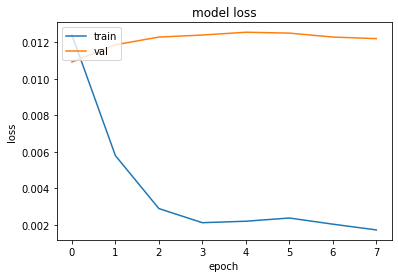

In [34]:
from matplotlib import pyplot as plt

plt.plot(historico.history['loss'])
plt.plot(historico.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

mse:  0.5288135026538823


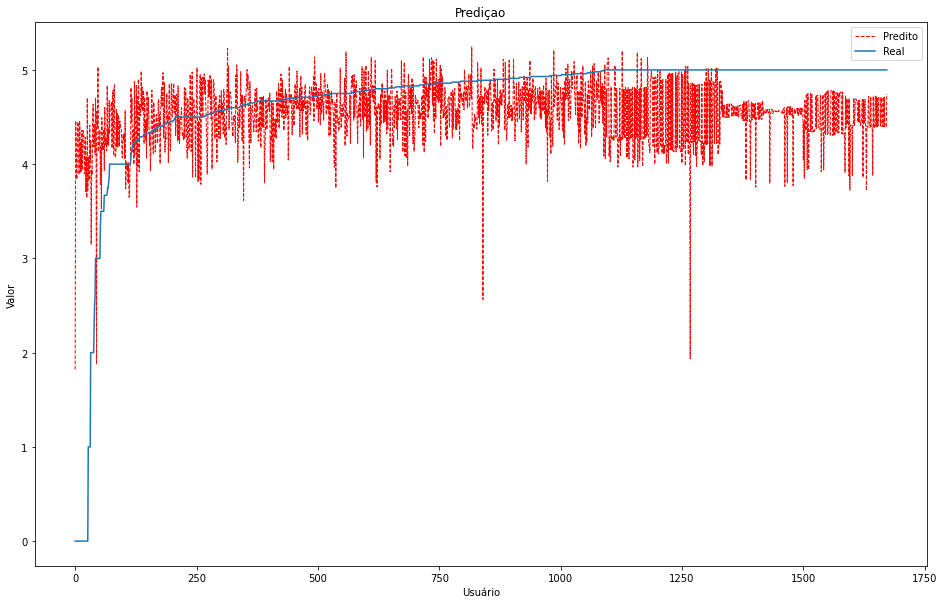

In [19]:
from matplotlib import pyplot as plt
import pandas as pd

resultadoRS = model.predict([X1_test,X2_test,X3_test,X4_test]).ravel()
esperadoRS = y_test.ravel()

mse = np.mean((np.array(esperadoRS) - np.array(resultadoRS))**2)
print('mse: ',mse)

indices = np.arange(0,resultadoRS.shape[0],1)
d = {'user':indices, 'real':esperadoRS,'predito':resultadoRS}
df_result = pd.DataFrame(d)
df_result = df_result.sort_values(by='predito')
df_result = df_result.sort_values(by='real')

y_real_sorted = df_result['real'].values
y_predict_sorted = df_result['predito'].values

plt.figure(num = 3, figsize=(16, 10))
plt.plot(indices,y_predict_sorted, label = "Predito",color='red', linewidth=1.0,  linestyle='--')
plt.plot(indices,y_real_sorted, label = "Real")
plt.xlabel("Usuário")
plt.ylabel("Valor")
plt.title("Prediçao")
plt.legend()
plt.show()

Como vemos, os resultados tem um mse maior que utilizando os textos dos reviews. No entanto, é curioso que a previsão aparenta se ajustar melhor a curva que os demais resultados.